In [3]:
import pandas as pd  # Data tables
import numpy as np   # Arrays/math
import matplotlib.pyplot as plt  # Visualizations
from statsmodels.tsa.stattools import adfuller  # Stationarity test (optional refresher)

import pymc as pm    # Bayesian modeling
import arviz as az   # Model diagnostics/plots

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Week 11 challenge\brent-oil-change-point-analysis\venv\Lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Load data

In [5]:
df = pd.read_csv('../data/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())  # Quick check: Should show 1987 start

C:\Users\bezaw\AppData\Local\Temp\ipykernel_12272\3197610254.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63


Compute transforms (explain: Log price stabilizes variance;log returns make stationary for better modeling)

In [6]:
df['Log_Price'] = np.log(df['Price'])
df['Log_Return'] = df['Log_Price'] - df['Log_Price'].shift(1)
df = df.dropna()  # Drop first NaN

Subset to 2012-2022 (explain: Focuses on recent data-matches events, reduce MCMC compute time from 9000+ to ~2500 rows)

Subset shape: (2760, 4)


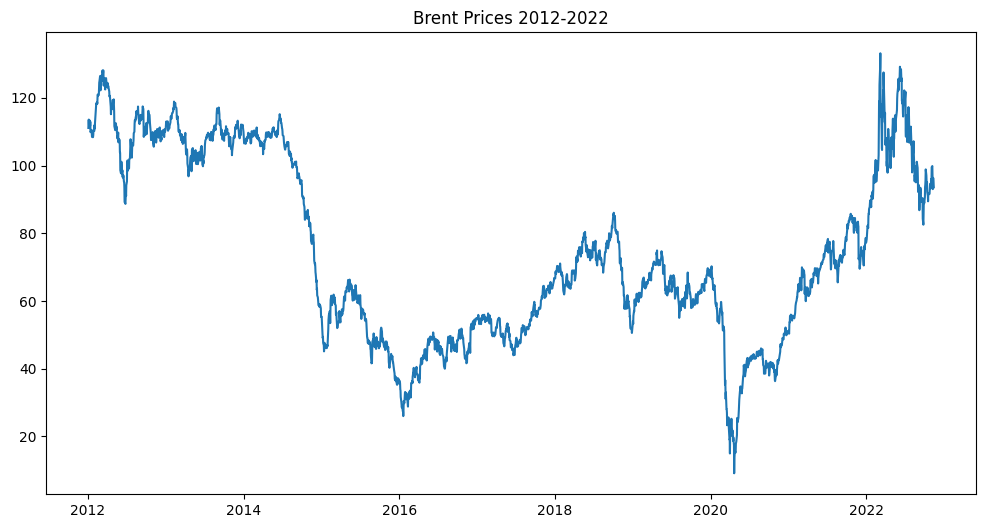

In [ ]:
df_recent = df[(df['Date'] >= '2012-01-01') & (df['Date'] <= '2022-12-31')].copy()
df_recent.reset_index(drop=True, inplace=True)  # New index 0 to len-1 for tau
print(f'Subset shape: {df_recent.shape}')  # ~ (2500+, 5 columns)
plt.figure(figsize=(12,6))
plt.plot(df_recent['Date'], df_recent['Price'])
plt.title('Brent Prices 2012-2022')
plt.show()  

New subset shape: (1239, 4)


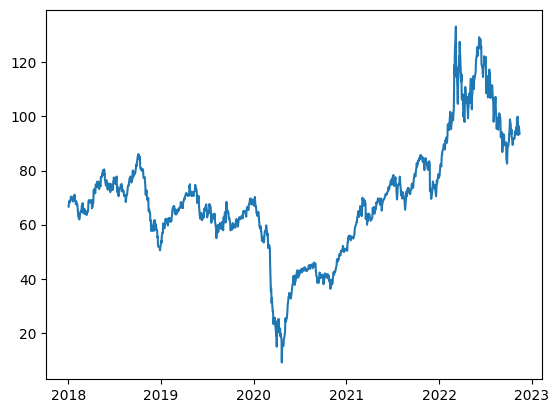

In [9]:
df_recent = df_recent[df_recent['Date'] >= '2018-01-01'].copy()  # Or '2020-01-01' for even smaller (~600)
df_recent.reset_index(drop=True, inplace=True)
print(f'New subset shape: {df_recent.shape}')  # Verify: Smaller N
plt.plot(df_recent['Date'], df_recent['Price'])  # Still captures key events (e.g., COVID, Ukraine)

 Prep data array (explain: PyMC needs numpy array; indices for tau)

In [8]:
data = df_recent['Log_Price'].values
n_points = len(data)  # Number of days

with pm.Model() as model:  # Context for model building
    # Prior for tau: Uniform over possible days (explain: Equal chance any day is change point)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_points - 1)
    
    # Priors for means: Normal, broad (explain: Weak info—lets data drive; mu=0 covers log price range ~2-5)
    mu1 = pm.Normal('mu1', mu=0, sigma=10)
    mu2 = pm.Normal('mu2', mu=0, sigma=10)
    
    # Shared sigma: HalfNormal (positive) (explain: Assumes constant variance; can extend later)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Switch mean: (explain: For each time t, if t < tau use mu1, else mu2)
    idx = np.arange(n_points)
    mu = pm.math.switch(tau > idx, mu1, mu2)  # Note: > for after (adjust if needed)
    
    # Likelihood: Data ~ Normal around switched mu (explain: Connects model to data)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)
    
    # Sample: MCMC to estimate posteriors (explain: Simulates 1000s of scenarios; tune burns in, chains for robustness)
    trace = pm.sample(2000, tune=1000, chains=2, return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Week 11 
challenge\brent-oil-change-point-analysis\venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 173 draw iterations (2_000 + 346 draws total) took 5690 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Summary (explain: Stats on posteriors; ess = effective samples, high=good)

          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    721.986  4.489  715.000  731.000      0.572    0.320      63.0   
mu1      4.680  0.011    4.661    4.702      0.001    0.001     362.0   
mu2      4.079  0.006    4.067    4.089      0.000    0.000     450.0   
sigma    0.281  0.004    0.274    0.287      0.000    0.000     547.0   

       ess_tail  r_hat  
tau       105.0   1.01  
mu1       206.0   1.00  
mu2       332.0   1.00  
sigma     254.0   1.01  


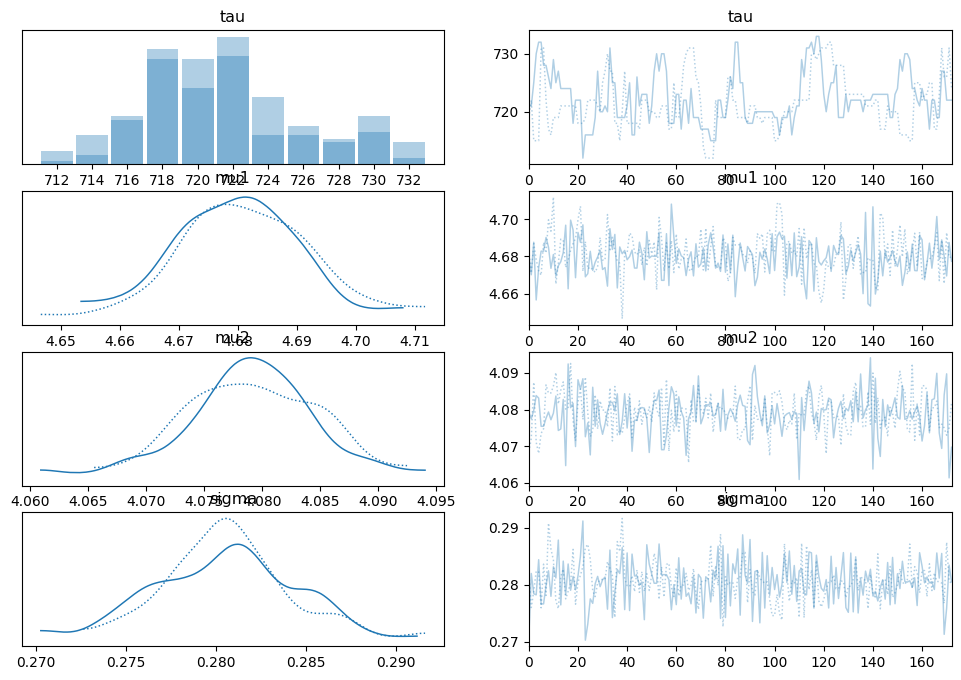

In [10]:
print(az.summary(trace))

# Trace plots (explain: Left: Distribution; Right: Chain paths—no stuck chains)
az.plot_trace(trace)
plt.show()

Tau posterior (explain: Histogram—mode/median = best guess date)

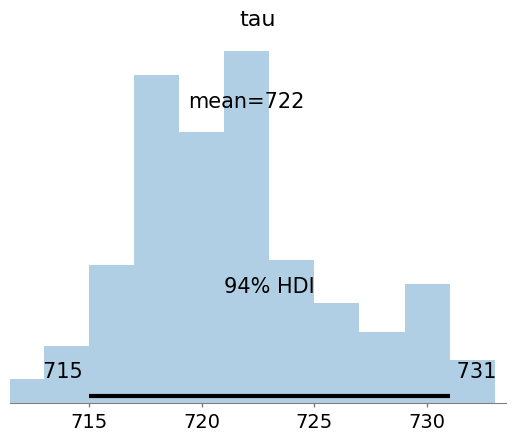

Most likely change point: 2020-10-27 00:00:00 (index 719)


In [13]:
# Cell 7: Tau posterior (no changes here)
az.plot_posterior(trace, var_names=['tau'])
plt.show()

tau_samples = trace.posterior['tau'].values.flatten()
values, counts = np.unique(tau_samples, return_counts=True)  # Get unique values and their frequencies
most_likely_tau = int(values[np.argmax(counts)])  # Index of max count = mode
change_date = df_recent['Date'].iloc[most_likely_tau]
print(f'Most likely change point: {change_date} (index {most_likely_tau})')

 Mu posteriors and impact (explain: Compare before/after; exp back to prices for interpretability)

Before: Log 4.68 (~$107.81)
After: Log 4.08 (~$59.09)
Change: -45.2%


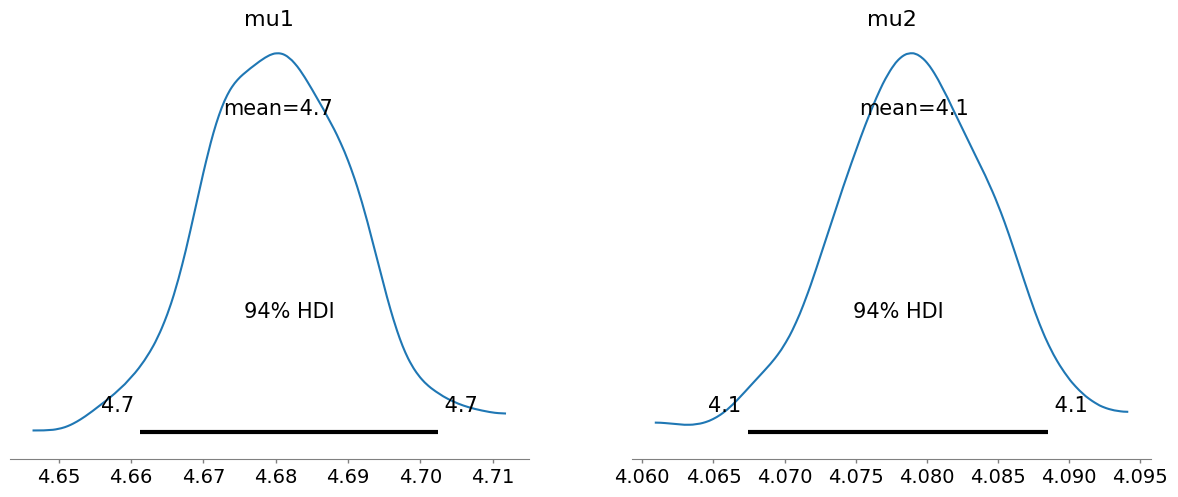

In [14]:
az.plot_posterior(trace, var_names=['mu1', 'mu2'])
mu1_mean = trace.posterior['mu1'].mean().values
mu2_mean = trace.posterior['mu2'].mean().values
price1 = np.exp(mu1_mean)
price2 = np.exp(mu2_mean)
percent_change = (price2 - price1) / price1 * 100
print(f'Before: Log {mu1_mean:.2f} (~${price1:.2f})')
print(f'After: Log {mu2_mean:.2f} (~${price2:.2f})')
print(f'Change: {percent_change:.1f}%')

Load events (explain: Compare dates)

In [15]:
events_df = pd.read_csv('../data/oil_events.csv')
events_df['Date'] = pd.to_datetime(events_df['Date'])

# Closest events (explain: Find temporal matches; +/- few days ok)
delta = (events_df['Date'] - change_date).abs()
closest = events_df.loc[delta.nsmallest(3).index]
print(closest)

         Date                                        Description  Category
10 2020-04-12          OPEC+ agrees to historic cuts of 9.7M bpd      OPEC
9  2020-03-11  COVID-19 declared a pandemic, global demand co...  Economic
8  2020-03-06  OPEC+ price war begins after Saudi-Russia disa...      OPEC
